In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e2/sample_submission.csv
/kaggle/input/playground-series-s3e2/train.csv
/kaggle/input/playground-series-s3e2/test.csv


<h2>Loading Libraries</h2>

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e2/train.csv', index_col='id')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e2/test.csv', index_col='id')
train_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


<h2>EDA</h2>

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15304 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  object 
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  object 
 5   work_type          15304 non-null  object 
 6   Residence_type     15304 non-null  object 
 7   avg_glucose_level  15304 non-null  float64
 8   bmi                15304 non-null  float64
 9   smoking_status     15304 non-null  object 
 10  stroke             15304 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


<h3>Null values<h3>

In [5]:
def nan_finder(df):
    nan_df = (100 * df.isnull().sum() / len(df)).round(2)
    name = [x for x in globals() if globals()[x] is df][0]
    nan_df.name = name + ' Nan freq.(%)'
    return nan_df.sort_values(ascending = False)

nan_train_test = pd.concat([nan_finder(train_df), nan_finder(test_df)], axis =1)
nan_train_test

,train_df Nan freq.(%),test_df Nan freq.(%)
gender,0.0,0.0
age,0.0,0.0
hypertension,0.0,0.0
heart_disease,0.0,0.0
ever_married,0.0,0.0
work_type,0.0,0.0
Residence_type,0.0,0.0
avg_glucose_level,0.0,0.0
bmi,0.0,0.0
smoking_status,0.0,0.0


There are no Nan values in the train or test dataset, nor there are null-like placeholders (?-missing-...) as can be verified by a direct look at the data.

<h3>Target distribution</h3>

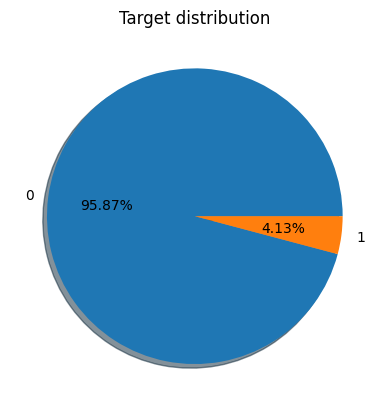

In [6]:
target_perc = (100 * train_df['stroke'].value_counts(normalize=True)).round(2)
fig, axes = plt.subplots(1,1)
axes.pie(target_perc.values, labels = target_perc.index, autopct = '%1.2f%%', shadow = True)
axes.set_title('Target distribution')
plt.show()

The target distribution is uneven, suggesting the use of stratified folding in the model selection.

In [7]:
X = train_df.copy()
y = train_df['stroke']
cat_cols = [cname for cname in X.columns if (X[cname].dtype == 'object' or X[cname].nunique() <= 10) and cname != 'stroke']
num_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64'] and X[cname].nunique() > 10]
print('categorical features:\n', cat_cols)
print('-'*90)
print('numerical features:\n', num_cols)

categorical features:
 ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
------------------------------------------------------------------------------------------
numerical features:
 ['age', 'avg_glucose_level', 'bmi']


<h3>Numerical features analysis</h3>

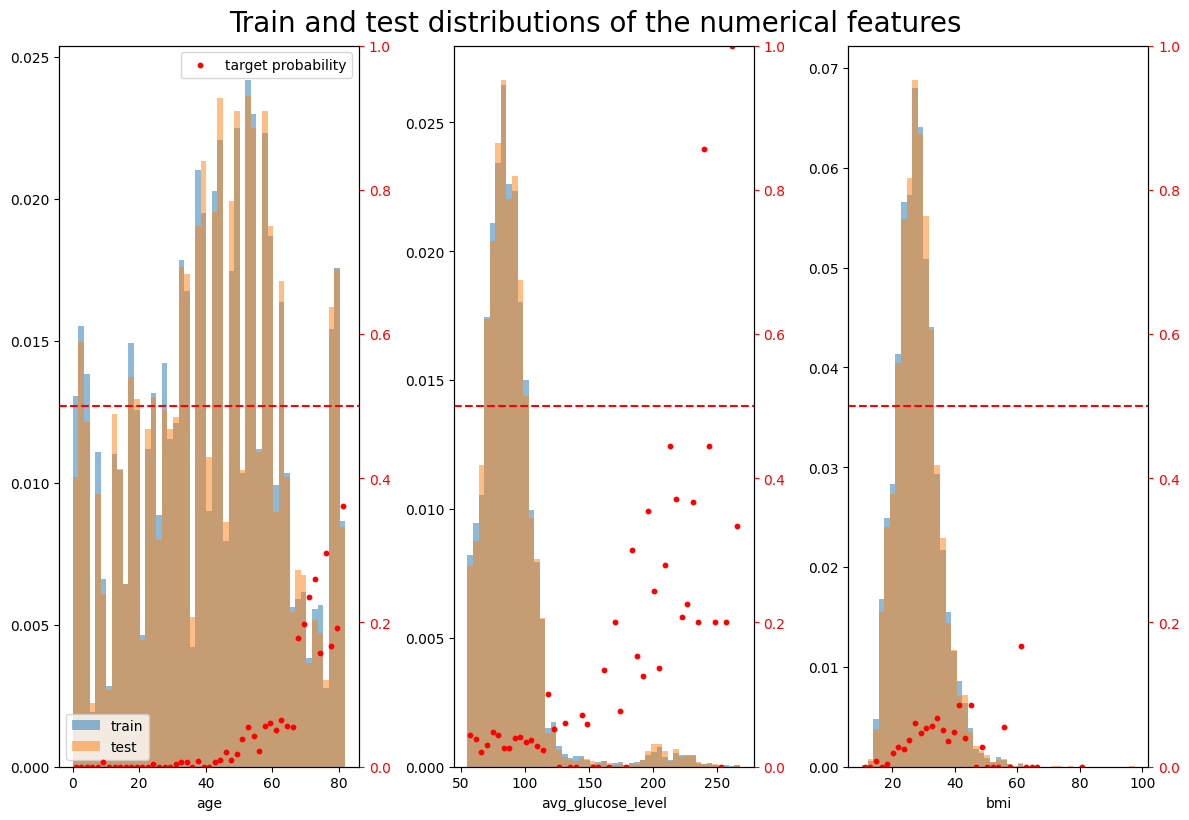

In [8]:
def num_distr_plotter(cols, target, train, test):
    rows = int(np.ceil(len(num_cols)/3))
    fig, axes = plt.subplots(rows, 3, figsize=(12,8))
    for col, ax in zip(cols, axes.ravel()):
        min_val = min(train[col].min(), test[col].min())
        max_val = max(train[col].max(), test[col].max())
        bins = np.linspace(min_val, max_val, 50)
        ax.hist(train[col], bins=bins, alpha=0.5, density=True, label ='train')
        ax.hist(test[col], bins=bins, alpha=0.5, density=True, label='test')
        ax.set_xlabel(col)
        if ax == axes.flat[0] : ax.legend(loc='lower left')
        ax2 = ax.twinx()
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=RuntimeWarning)
            total, _ = np.histogram(train[col], bins=bins)
            tar_val, _ = np.histogram(train[col][target == 1], bins=bins)
            ax2.scatter((bins[1:] + bins[:-1]) / 2, tar_val / total, s = 10, color = 'r', label='target probability')
            ax2.axhline(y=0.5, color='r', linestyle='--')
            ax2.set_ylim(0., 1.)
            ax2.tick_params(axis='y', colors='r')
            if ax == axes.flat[0] : ax2.legend(loc='upper right')
    plt.tight_layout(w_pad=1)
    plt.suptitle('Train and test distributions of the numerical features', fontsize=20, y=1.02)
    plt.show()

num_distr_plotter(num_cols, y, train_df, test_df)

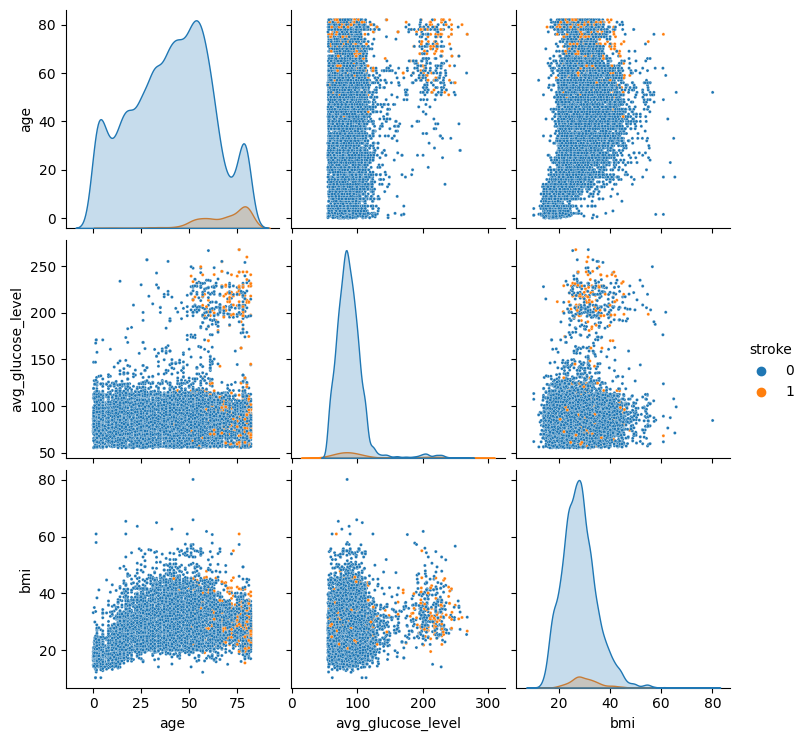

In [9]:
sns.pairplot(train_df, vars=num_cols, hue='stroke', plot_kws = {'s' : 5})

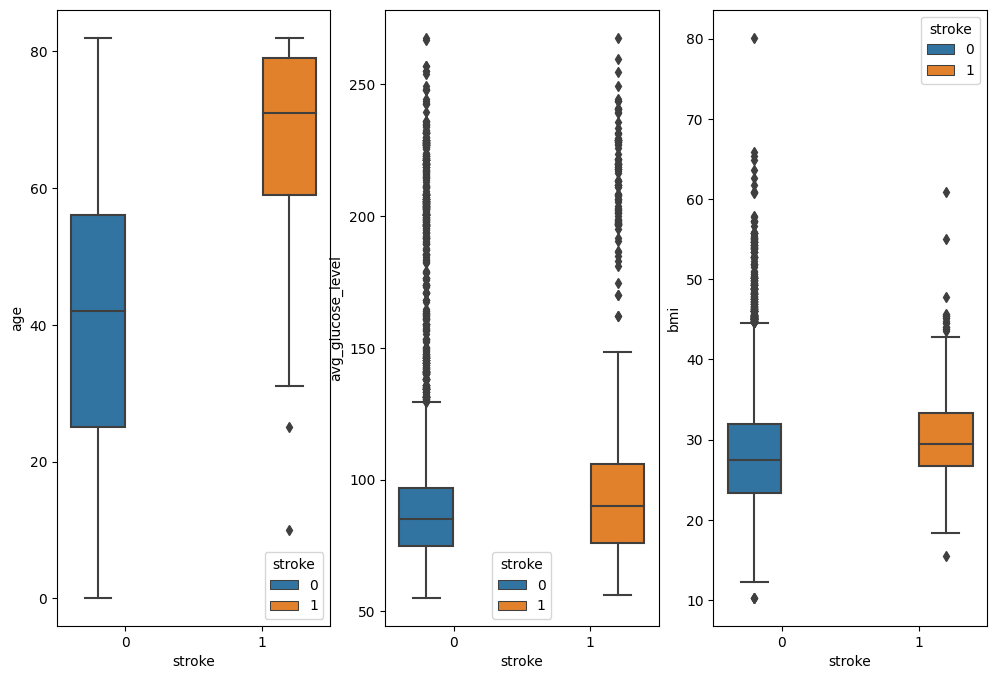

In [10]:
fig, axes = plt.subplots(1,3, figsize = (12, 8))
for col, ax in zip(num_cols, axes):
    sns.boxplot(train_df, x = 'stroke', y = col, hue='stroke', ax=ax)

**Insights:**
<ul>
    <li>All numerical features seem to be positively correlated to the target, however, for avg_gluvose_level and bmi there are out-of-trend samples (to investigate).</li>
    <li>As a consequence the mean values for avg_gluvose_level and bmi grouped by target value are similar.</li>
    <li>The avg_glucose_level distribution is skewed.</li>
</ul>

<h3>Categorical distribution</h3>

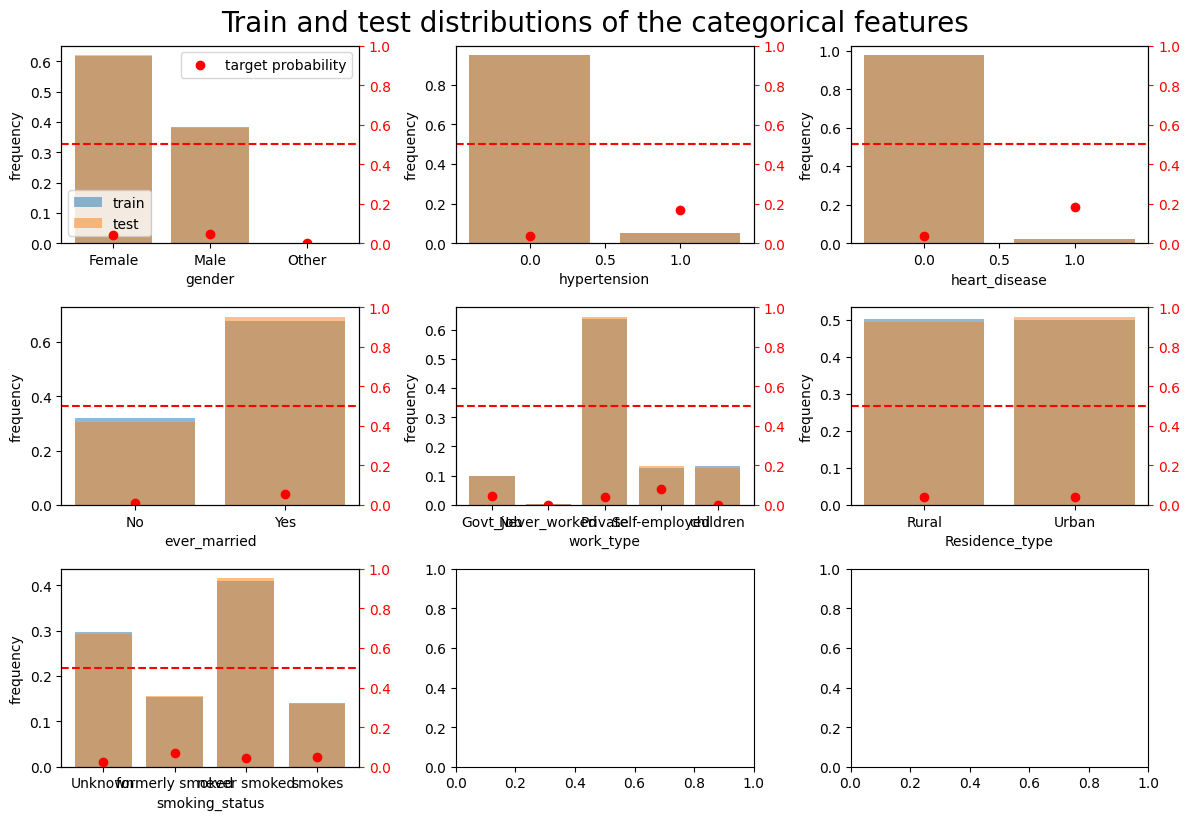

In [11]:
def cat_distr_plotter(cols, target, train, test):
    rows = int(np.ceil(len(cols)/3))
    _, axes = plt.subplots(rows,3, figsize=(12,8))
    for f, ax in zip(cols, axes.ravel()):
        train_gb = train[target].groupby(train[f]).agg(['mean', 'size'])
        ax.bar(train_gb.index, train_gb['size'] / len(train), alpha=0.5, label='train')
        test_gb = test[f].value_counts()
        ax.bar(test_gb.index, test_gb / len(test), alpha=0.5, label='test')
        ax.set_xlabel(f)
        if ax == axes.flat[0] : ax.legend(loc='lower left')
        ax.set_ylabel('frequency')
        ax2 = ax.twinx()
        ax2.scatter(train_gb.index, train_gb['mean'], color='r', label='target probability')
        ax2.axhline(y=0.5, color='r', linestyle='--')
        ax2.set_ylim(0., 1.)
        ax2.tick_params(axis='y', colors='r')
        if ax == axes.flat[0] : ax2.legend(loc='upper right')
    plt.tight_layout(w_pad=1)
    plt.suptitle('Train and test distributions of the categorical features', fontsize=20, y=1.02)
    plt.show()
    del train_gb, test_gb

cat_distr_plotter(cat_cols, 'stroke', train_df, test_df)

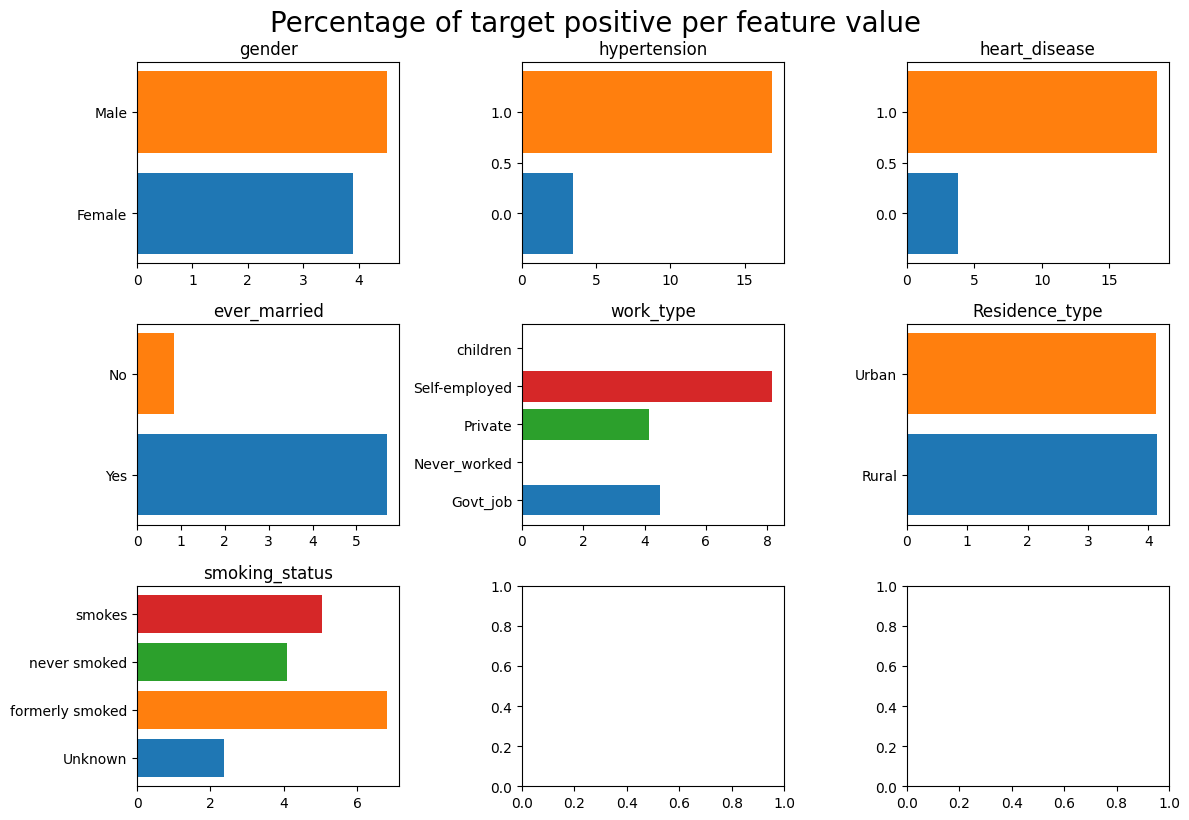

In [12]:
def cat_freq_plotter(cat_cols, target, df):
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    rows = int(np.ceil(len(cat_cols)/3))
    _, axes = plt.subplots(rows,3, figsize=(12,8))
    for col, ax in zip(cat_cols, axes.ravel()):
        df_perc = 100 * df[col][target == 1].value_counts() / df[col].value_counts()
        color = colors[:df[col].nunique()]
        ax.barh(y = df_perc.index, width = df_perc.values, color=color)
        ax.set_title(col)
    plt.tight_layout(w_pad = 1)
    plt.suptitle('Percentage of target positive per feature value', fontsize=20, y=1.02)
    plt.show()
    
cat_freq_plotter(cat_cols, y, train_df)

**Insights:**
<ul>
    <li>Hypertension, heat_disease, ever_married (oh well), work_type and smoking_status distribution has a correlation with the target.</li>
    <li>Interestingly "formely smoked" has a higher chance of a stroke that the "smokes category, this is possibly due to the fact that people who formerly smoked are generally older (as shown below) and a) could have smoked for more time, b) age is strongly correlated to stroke probability.</li>
</ul>

In [13]:
print('Mean "formerly smoked" age: ', train_df[train_df['smoking_status'] == 'formerly smoked']['age'].mean())
print('Mean "smokes" age: ', train_df[train_df['smoking_status'] == 'smokes']['age'].mean())

Mean "formerly smoked" age:  54.293059477963205
Mean "smokes" age:  45.269715352309845


<h2>Preprocessing</h2>

The preprocessing just consists of:
<ul>
    <li>Log-transform the avg_glucose_level feature to correct its skewness, as well as bmi (this could be unnecessary).</li>
    <li>We eliminate outliers in the bmi category to avoid possibly odd data.</li>
</ul>

In [14]:
bmi_upper_boundary = train_df['bmi'].mean() + 3*train_df['bmi'].std()
bmi_upper_boundary

48.2796671239755

In [15]:
X = X[X['bmi'] <= bmi_upper_boundary]
clipped_y = y.loc[train_df['bmi'] <= bmi_upper_boundary]
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15179 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15179 non-null  object 
 1   age                15179 non-null  float64
 2   hypertension       15179 non-null  int64  
 3   heart_disease      15179 non-null  int64  
 4   ever_married       15179 non-null  object 
 5   work_type          15179 non-null  object 
 6   Residence_type     15179 non-null  object 
 7   avg_glucose_level  15179 non-null  float64
 8   bmi                15179 non-null  float64
 9   smoking_status     15179 non-null  object 
 10  stroke             15179 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


In [16]:
clipped_y.shape

(15179,)

In [17]:
for col in ['avg_glucose_level', 'bmi']:
    X[col] = np.log(1 + X[col])
    test_df[col] = np.log(1 + test_df[col])

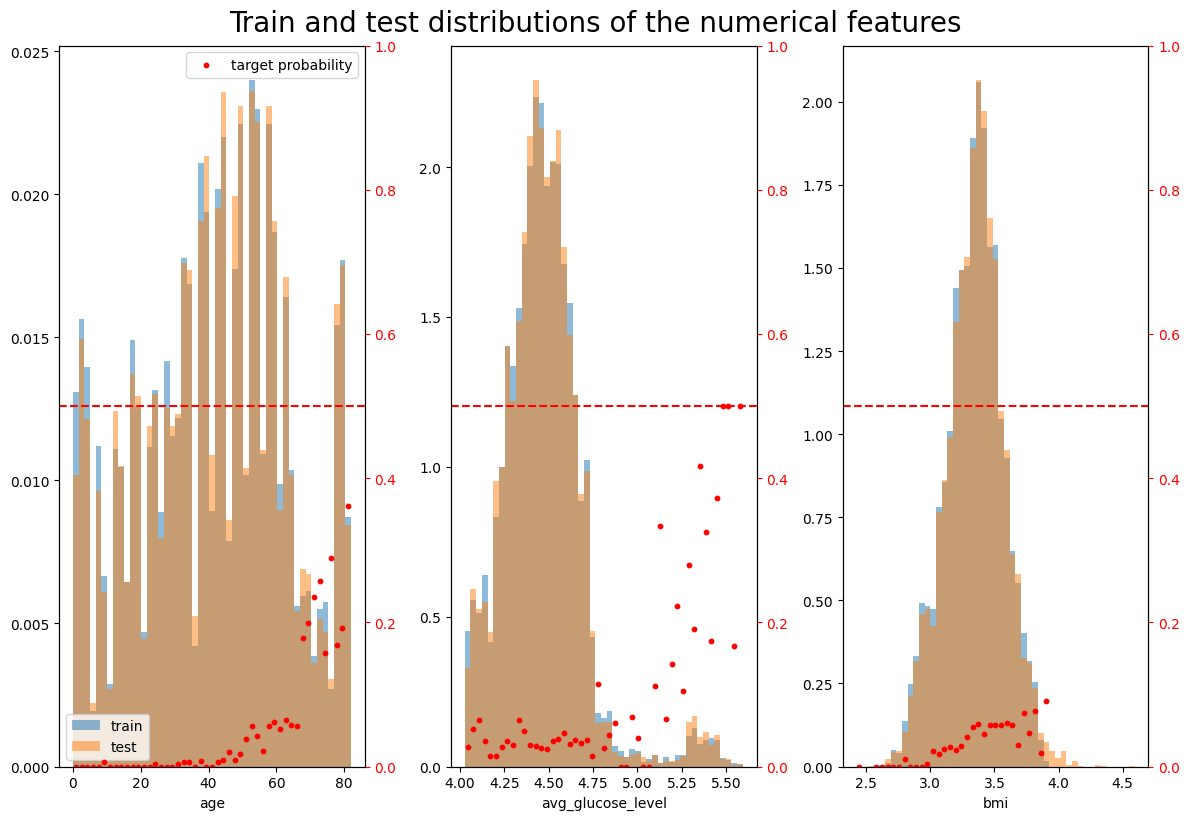

In [18]:
num_distr_plotter(num_cols, clipped_y, X, test_df)

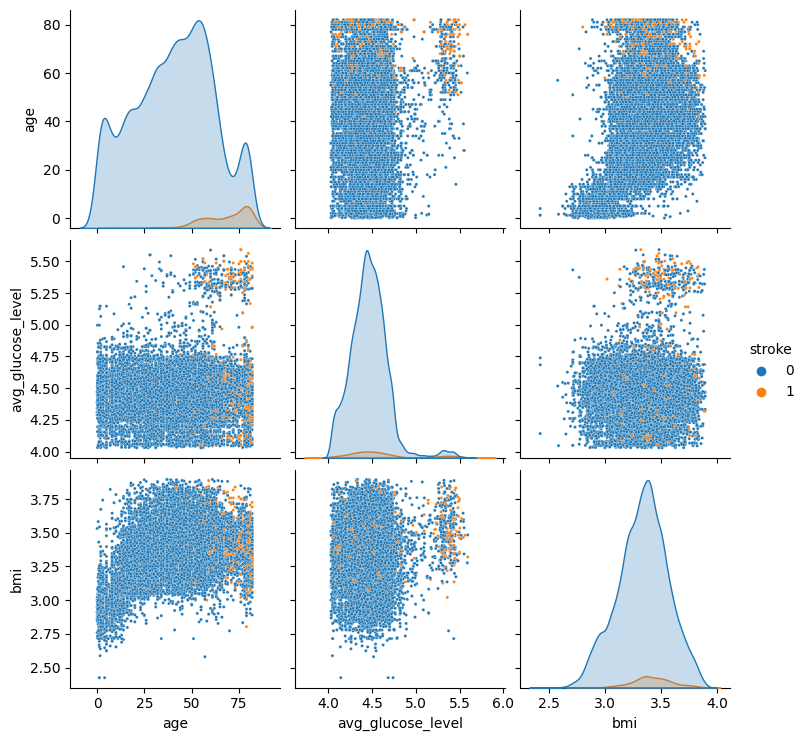

In [19]:
sns.pairplot(X, vars=num_cols, hue='stroke', plot_kws = {'s' : 5})

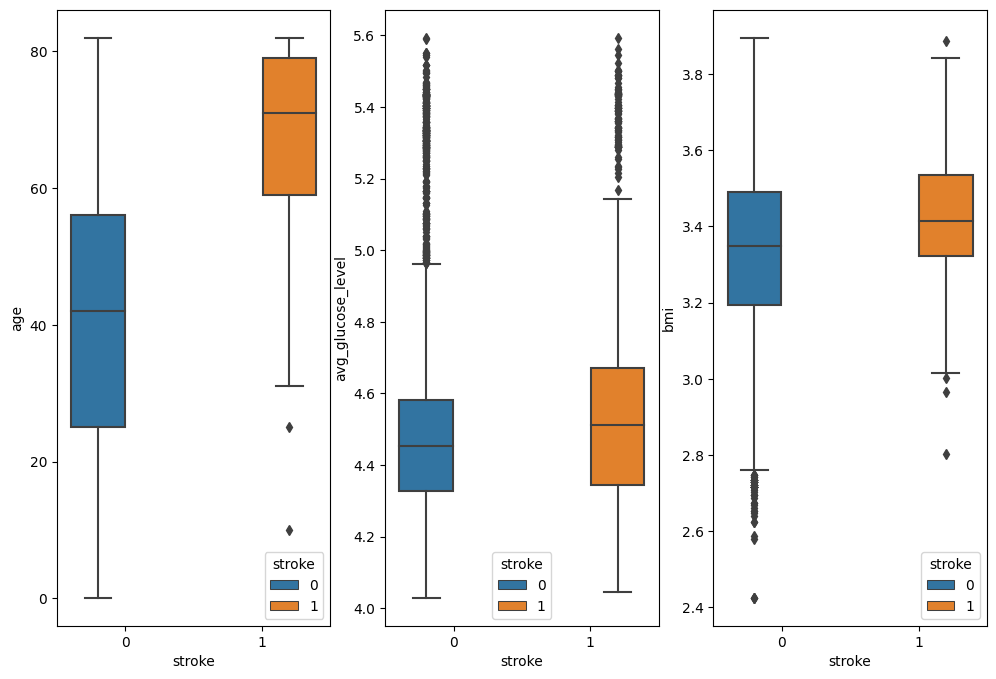

In [20]:
fig, axes = plt.subplots(1,3, figsize = (12, 8))
for col, ax in zip(num_cols, axes):
    sns.boxplot(X, x = 'stroke', y = col, hue='stroke', ax=ax)

<h2>Model selection</h2>

For the model we select an extreme gradient boosting algorithm, and perform grid-search cross validation:

In [21]:
my_nums = ['age', 'avg_glucose_level', 'bmi']
my_cats = ['hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'smoking_status']

my_feats = my_nums + my_cats
X_train = X[my_feats].copy()
y_train = X['stroke']

In [22]:
num_pipeline = Pipeline([
    ('scaler', RobustScaler()),
])
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, my_nums),
    ('cat', cat_pipeline, my_cats),
])

xgb_clf = XGBClassifier()

full_pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('xgb', xgb_clf),
])

In [23]:
parameters = {'xgb__min_child_weight': [1, 2],
              'xgb__max_depth': [4, 6],
              'xgb__gamma': [0.1, 0.2],
              'xgb__learning_rate': [0.05, 0.5, 0.3]}

skfold = StratifiedKFold(n_splits = 5)

xgb_grid = GridSearchCV(full_pipeline, cv = skfold, param_grid = parameters, scoring = 'roc_auc', n_jobs  = -1)

xgb_grid.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['hypertension',
                                                                          'heart_disease',
                                                                          'ever_ma...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__gamma': [0.1, 0.2],
                         'xgb__learning_rate': [0.05, 0.5, 0.3],
                         'xgb__max_depth': [4, 6],
                         'xgb__min_child_weight': [1, 2]},
             scoring='roc_auc')

In [24]:
xgb_grid.best_score_

0.8857075230987512

In [25]:
xgb_grid.best_params_

{'xgb__gamma': 0.2,
 'xgb__learning_rate': 0.05,
 'xgb__max_depth': 4,
 'xgb__min_child_weight': 1}

In [26]:
best_xgb = XGBClassifier(gamma = 0.2, learning_rate = 0.05, max_depth = 4, min_child_weight = 1)

best_pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('best_xgb', best_xgb), 
])

best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hypertension',
                                                   'heart_disease',
                                                   'ever_married', 'work_type',
                                                   'smoking_status'])])),
                ('best_xgb',
                 XGBClassifier(base_score=None, boo...
                               feature_types=None, gamma=0.2, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [27]:
y_preds = best_pipeline.predict_proba(test_df)
y_preds[:10]

array([[0.95744056, 0.04255946],
       [0.8085708 , 0.19142921],
       [0.9985395 , 0.0014605 ],
       [0.9456877 , 0.05431231],
       [0.99324155, 0.00675846],
       [0.97681713, 0.02318284],
       [0.9961809 , 0.00381909],
       [0.9479355 , 0.05206447],
       [0.99857026, 0.00142971],
       [0.968206  , 0.03179399]], dtype=float32)